#### Main Computation

In [4]:
# - Base
import os, re, ast, glob, pathlib
import xraydb

# - Scipy/Numpy
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import ConvexHull
from scipy.optimize import curve_fit
from scipy.spatial.distance import pdist, squareform

# - Visuals
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from tqdm.auto import tqdm

# - Threading/Multiprocessing
# import dask.array as da
# from dask.distributed import Client
from concurrent.futures import ThreadPoolExecutor, as_completed
import numexpr as ne

## - Load ptable and atomic_masses
def load_tabledata(filename):
    """
    Load data from a specified file, assuming the file contains a dictionary definition.

    Parameters:
    - filename (str): The name of the file to load data from.

    Returns:
    - dict: The dictionary of data loaded from the file.
    """
    dir_path = os.getcwd()
    full_path = os.path.join(dir_path, filename)

    try:
        with open(full_path, 'r') as file:
            data = file.read()
        data_dict = data.split('=', 1)[1].strip()
        table = ast.literal_eval(data_dict)
        return table
    except FileNotFoundError:
        print(f"File not found: {full_path}")
        return {}
    except SyntaxError as e:
        print(f"Error reading the data: {e}")
        return {}
    
## - Load XYZ files for the calculation
def loadXYZ(xyzPath):
    """
    Loads atomic coordinates and elements from an XYZ file.

    Parameters:
    - xyzPath (str): The path to the XYZ file.

    Returns:
    - tuple: A tuple containing numpy arrays of coordinates and elements.
    """
    with open(xyzPath, 'r') as file:
        lines = file.readlines()
    atom_data = [line.split() for line in lines[2:] if len(line.split()) == 4]
    elements, coords = zip(*[(parts[0], np.array(list(map(float, parts[1:])))) for parts in atom_data])

    return np.array(coords), np.array(elements)

## - Evaluate the number of threads available for an io-bound or cpu-bound task.
# Note: Seems like this calculation is CPU-bound, or at least the compute segment that uses the multi-threading approach.
def determine_safe_thread_count(task_type='cpu', max_factor=2):
    # Get the number of CPU cores
    num_cores = os.cpu_count() or 1  # Fallback to 1 if os.cpu_count() returns None

    if task_type == 'cpu':
        # For CPU-bound tasks: use a minimum of 1 and a maximum of num_cores
        thread_count = max(1, num_cores - 1)
    elif task_type == 'io':
        # For I/O-bound tasks: consider using more threads
        thread_count = max(1, num_cores * max_factor)
    else:
        raise ValueError("task_type must be 'cpu' or 'io'")

    return thread_count

def compute_sq_for_q(q_val, rij_matrix, f0_q_elements):
    """
    Computes the Debye scattering for a given q value.
    
    Parameters:
    - q_val: tuple containing the q value and its index.
    - rij_matrix: matrix of interatomic distances.
    - f0_q_elements: adjusted atomic scattering factors for this q value.
    
    Returns:
    - float: Scattering intensity for this q value.
    """
    f0_q = f0_q_elements[:, q_val[1]]  # Atomic scattering factors for this q value
    rij_q = rij_matrix * q_val[0]  # Pre-multiply rij by q_val to avoid repetitive computation
    sinc_rij_q = np.sinc(rij_q / np.pi)  # np.sinc includes division by pi
    return np.sum(np.outer(f0_q, f0_q) * sinc_rij_q)

def sq_with_f0_contrast(pos, elements, qs, f0_avg):
    """
    Calculates the scattering profile using the Debye equation with atomic scattering factors
    adjusted for contrast based on f0_avg.
    
    Parameters:
    - pos: scatterer positions in 3D Cartesian coordinates (nx3 array).
    - elements: 1D array of strings representing the element symbols for each scatterer.
    - f0_avg: 1D array representing the average f0(q) curve.
    - qs: list of q values to evaluate scattering intensity at.
    
    Returns:
    - numpy array: Scattering profile S(q) for the given q values.
    """
    nbins = len(qs)
    sq = np.zeros(nbins)
    rij_matrix = squareform(pdist(pos, metric='euclidean'))
    
    # Identify unique elements and precompute f0 for each element and each q value
    unique_elements = np.unique(elements)
    f0_dict = {element: np.array([xraydb.f0(element, q/(4 * np.pi))[0] for q in qs]) for element in unique_elements}

    # Map precomputed f0 values to the elements array and adjust with f0_avg
    f0_q_elements = np.array([f0_dict[element] for element in elements])
    # f0_q_elements *= f0_scales[:, np.newaxis]
    # # if f0_avg is not None:
    # f0_q_elements -= f0_avg[np.newaxis, :]  # Subtract f0_avg from each element's f0_q_elements
    
    # # Determine the number of threads to use based on the environment (CPU-bound operation)
    max_workers = determine_safe_thread_count(task_type='cpu')
    print('Number of Max Workers: ', str(max_workers))
    
    # with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust max_workers to your environment
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(compute_sq_for_q, 
                                   (q_val, i), 
                                   rij_matrix, 
                                   f0_q_elements): i for i, q_val in enumerate(qs)}
        for future in tqdm(as_completed(futures), total=len(futures)):
            sq[futures[future]] = future.result()

    return sq

def sq_with_f0_threaded(pos, elements, qs):
    """
    Calculates the scattering profile using the Debye equation with atomic scattering factors
    adjusted for contrast based on f0_avg.
    
    Parameters:
    - pos: scatterer positions in 3D Cartesian coordinates (nx3 array).
    - elements: 1D array of strings representing the element symbols for each scatterer.
    - f0_avg: 1D array representing the average f0(q) curve.
    - qs: list of q values to evaluate scattering intensity at.
    
    Returns:
    - numpy array: Scattering profile S(q) for the given q values.
    """
    nbins = len(qs)
    sq = np.zeros(nbins)
    rij_matrix = squareform(pdist(pos, metric='euclidean'))
    
    # Identify unique elements and precompute f0 for each element and each q value
    unique_elements = np.unique(elements)
    f0_dict = {element: np.array([xraydb.f0(element, q/(4 * np.pi))[0] for q in qs]) for element in unique_elements}

    # Map precomputed f0 values to the elements array and adjust with f0_avg
    f0_q_elements = np.array([f0_dict[element] for element in elements])
    
    # Determine the number of threads to use based on the environment (CPU-bound operation)
    max_workers = determine_safe_thread_count(task_type='cpu')
    print('Number of Max Workers: ', str(max_workers))
    
    # with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust max_workers to your environment
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(compute_sq_for_q, 
                                   (q_val, i), 
                                   rij_matrix, 
                                   f0_q_elements): i for i, q_val in enumerate(qs)}
        for future in tqdm(as_completed(futures), total=len(futures)):
            sq[futures[future]] = future.result()

    return sq

# def xyz_simulation(xyzPath, qs, exclude_hydrogen=True):
def xyz_simulation(xyzPath, qs):
    """
    Calculates the scattering intensity I(q) for a given molecular structure in an xyz file,
    concentration, and background solvent electron density. Molecular volume is calculated via
    convex hull and background solvent essentially subtracts "z" from each atom in molecule. 
    Note, atoms with Z/(volume/#atoms) less than solvent electron density are removed. 
    Complexity is O(n) for number of q-values and O(n^2) for the number of atoms in .xyz file

    Parameters:
    - xyzPath: string, path to xyz file of molecule, NP, etc.
    - qs: 1D array of q values which you would like intensity to be calculated.
    - vol_pct: float, volume percent of molecule in solution.
    - solvent_edens: float, electron density of solvent in e/Å^3.

    Returns:
    - iq_vals: 1D numpy array of absolute intensity values for each q in exp_file.
    """
    ptable = load_tabledata('ptable.txt')
    atomic_masses = load_tabledata('atomic_masses.txt')

    coords, elements = loadXYZ(xyzPath)

    # Compute scattering profile using f0_avg
    sq_vals = sq_with_f0_threaded(coords, elements, qs)
    
    # # Calculate f0_avg
    # f0_avg, _ = compute_average_f0(np.array(elements), qs, exclude_hydrogen=exclude_hydrogen)

    # # Calculate electron density and adjust for solvent contrast
    # adjusted_electrons = np.array([ptable[element] for element in elements])

    # if exclude_hydrogen == True:
    #     filter_setpoint = 1
    # else:
    #     filter_setpoint = 0

    # # Filter scatterers based on electron density
    # mask = adjusted_electrons > filter_setpoint
    # debye_scatterers = np.array(coords)[mask]
    # debye_species = np.array(elements)[mask]

    # # Compute scattering profile using f0_avg
    # sq_vals = sq_with_f0_contrast(debye_scatterers, debye_species, qs, f0_avg=None)
    
    # r0 = 2.82e-13  # Thomson scattering length of electron (cm)
    # correction_fact = (vol_pct * (r0**2)) / (molecular_volume * 1e-24)
    
    # iq_vals = sq_vals * correction_fact  # absolute intensity (cm^-1)
    
    # Return the scattering profile without intensity correction
    return sq_vals

def plot_scattering_profile(qs, sq_vals, log_x=True, log_y=True):
    """
    Plots the scattering intensity S(Q) versus Q.

    Parameters:
    - qs (numpy array): 1D array of q values.
    - sq_vals (numpy array): 1D array of scattering intensity values corresponding to the q values.
    - log_x (bool): If True, sets the x-axis to a log scale. Default is True.
    - log_y (bool): If True, sets the y-axis to a log scale. Default is True.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(qs, sq_vals, marker='o', linestyle='-', color='b', label='S(Q)')
    plt.xlabel('Q (Å⁻¹)')
    plt.ylabel('S(Q)')
    plt.title('Scattering Intensity vs Q')
    
    if log_x:
        plt.xscale('log')
    if log_y:
        plt.yscale('log')
    
    plt.legend()
    plt.grid(True)
    plt.show()

def calculate_and_save_scattering(folder_path, output_folder, qs, exclude_hydrogen=True):
    """
    Calculates and saves the scattering patterns for each .xyz file in a specified folder.
    
    Parameters:
    - folder_path (str): Path to the folder containing the .xyz files.
    - output_folder (str): Path to the folder where the .txt files will be saved.
    - qs (numpy array): 1D array of q values which you would like intensity to be calculated.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    scattering_patterns = []

    # Loop through each .xyz file in the folder
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith('.xyz'):
            xyz_path = os.path.join(folder_path, filename)
            
            # Calculate the scattering pattern
            sq_vals = xyz_simulation(xyz_path, qs, exclude_hydrogen=exclude_hydrogen)
            scattering_patterns.append(sq_vals)
            
            # Save the scattering pattern to a .txt file
            output_file = os.path.join(output_folder, filename.replace('.xyz', '.txt'))
            np.savetxt(output_file, np.column_stack((qs, sq_vals)), header='Q (Å⁻¹)  S(Q)', comments='')
    
    return np.array(scattering_patterns)

def average_and_save_scattering(scattering_patterns, qs, output_folder):
    """
    Averages the scattering patterns and saves the averaged data to a .txt file.
    
    Parameters:
    - scattering_patterns (numpy array): Array containing the scattering patterns.
    - qs (numpy array): 1D array of q values.
    - output_folder (str): Path to the folder where the averaged data will be saved.
    """
    # Calculate the average scattering pattern
    avg_sq_vals = np.mean(scattering_patterns, axis=0)
    
    # Save the averaged scattering pattern to a .txt file
    avg_output_file = os.path.join(output_folder, 'average_scattering.txt')
    np.savetxt(avg_output_file, np.column_stack((qs, avg_sq_vals)), header='Q (Å⁻¹)  Avg_S(Q)', comments='')
    
    return avg_sq_vals

def interactive_average_and_plot(scattering_patterns, qs, log_x=True, log_y=True):
    """
    Averages the scattering patterns interactively and updates the plot.
    
    Parameters:
    - scattering_patterns (list): List of scattering patterns as they are being calculated.
    - qs (numpy array): 1D array of q values.
    - log_x (bool): If True, sets the x-axis to a log scale. Default is True.
    - log_y (bool): If True, sets the y-axis to a log scale. Default is True.
    """
    # Calculate the average scattering pattern so far
    avg_sq_vals = np.mean(scattering_patterns, axis=0)
    
    # Clear the output and update the plot
    clear_output(wait=True)
    plt.figure(figsize=(10, 6))
    plt.plot(qs, avg_sq_vals, marker='o', linestyle='-', color='b', label='Avg S(Q)')
    plt.xlabel('Q (Å⁻¹)')
    plt.ylabel('S(Q)')
    plt.title('Averaged Scattering Intensity vs Q')
    
    if log_x:
        plt.xscale('log')
    if log_y:
        plt.yscale('log')
    
    plt.legend()
    plt.grid(True)
    plt.show()

    # Return the current average scattering pattern
    return avg_sq_vals

def calculate_and_save_scattering_interactive(folder_path, output_folder, qs, log_x=True, log_y=True):
    """
    Calculates, saves, and interactively averages the scattering patterns for each .xyz file in a specified folder.
    
    Parameters:
    - folder_path (str): Path to the folder containing the .xyz files.
    - output_folder (str): Path to the folder where the .txt files will be saved.
    - qs (numpy array): 1D array of q values which you would like intensity to be calculated.
    - vol_pct (float): Volume percent of molecule in solution.
    - solvent_edens (float): Electron density of solvent in e/Å^3.
    - log_x (bool): If True, sets the x-axis to a log scale. Default is True.
    - log_y (bool): If True, sets the y-axis to a log scale. Default is True.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    scattering_patterns = []

    # Loop through each .xyz file in the folder
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith('.xyz'):
            xyz_path = os.path.join(folder_path, filename)
            
            # Calculate the scattering pattern
            sq_vals = xyz_simulation(xyz_path, qs)
            scattering_patterns.append(sq_vals)
            
            # Save the scattering pattern to a .txt file
            output_file = os.path.join(output_folder, filename.replace('.xyz', '.txt'))
            np.savetxt(output_file, np.column_stack((qs, sq_vals)), header='Q (Å⁻¹)  S(Q)', comments='')
            
            # Update the average and plot interactively
            interactive_average_and_plot(scattering_patterns, qs, log_x, log_y)


#### Computing f0 Average

In [2]:
import numpy as np
import xraydb
from scipy.spatial.distance import pdist, squareform
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
from tqdm import tqdm

def compute_f0_dict(elements, qs):
    """
    Computes the f0(q) values for each unique element in the list of elements.
    
    Parameters:
    - elements (numpy array): Array of atomic elements.
    - qs (numpy array): Array of q values.
    
    Returns:
    - dict: Dictionary of f0(q) curves for each element.
    """
    unique_elements = np.unique(elements)
    f0_dictionary = {element: np.array([xraydb.f0(element, q/(4 * np.pi))[0] for q in qs]) for element in unique_elements}
    return f0_dictionary

def compute_average_f0(elements, qs, exclude_hydrogen=False):
    """
    Computes the average atomic scattering factor f0(q) weighted by the number fraction of each element.
    
    Parameters:
    - elements (numpy array): Array of atomic elements.
    - qs (numpy array): Array of q values.
    - exclude_hydrogen (bool): If True, excludes hydrogen atoms from contributing to the average f0 value. Default is True.
    
    Returns:
    - numpy array: The average f0(q) for the given q values.
    - dict: Dictionary of f0(q) curves for each element.
    """
    if exclude_hydrogen:
        elements = elements[elements != 'H']

    f0_dictionary = compute_f0_dict(elements, qs)
    unique_elements, counts = np.unique(elements, return_counts=True)
    num_atoms = len(elements)
    
    f0_avg = np.zeros_like(qs)
    for element, count in zip(unique_elements, counts):
        f0_avg += (count / num_atoms) * f0_dictionary[element]
    
    return f0_avg, f0_dictionary

def compute_volume(coords, box_dims=None, verbose=False):
    """
    Computes the volume of the box. If dimensions are not provided,
    the volume is calculated dynamically based on the atom positions.
    
    Parameters:
    - coords (numpy array): Array of atomic coordinates.
    - box_dims (tuple): Optional. Tuple of box dimensions (x, y, z).
    - verbose (bool): Optional. If True, prints the computed volume and method used.
    
    Returns:
    - float: Volume of the box.
    """
    if box_dims:
        volume = np.prod(box_dims)
        method = "Provided box dimensions"
    else:
        mins = np.min(coords, axis=0)
        maxs = np.max(coords, axis=0)
        volume = np.prod(maxs - mins)
        method = "Dynamic calculation from atom positions"
    
    if verbose:
        print(f"Volume calculated using {method}: {volume:.2f} cubic angstroms")
    
    return volume

def plot_f0_curves(f0_dict, f0_avg, qs):
    """
    Plots the f0(q) curves for each element and the average f0(q).

    Parameters:
    - f0_dict (dict): Dictionary of f0(q) curves for each element.
    - f0_avg (numpy array): The average f0(q) curve.
    - qs (numpy array): Array of q values.
    """
    plt.figure(figsize=(10, 6))
    
    # Plot each element's f0(q)
    for element, f0_q in f0_dict.items():
        plt.plot(qs, f0_q, label=f'{element} f0(q)')
    
    # Plot the average f0(q)
    plt.plot(qs, f0_avg, label='Average f0(q)', color='black', linestyle='--', linewidth=2)
    
    plt.xlabel('q (inverse angstroms)')
    plt.ylabel('f0(q)')
    plt.title('Atomic Scattering Factors')
    plt.legend()
    plt.grid(True)
    plt.show()

def average_f0_contrast(xyzPath, qs, verbose=False):
    """
    Computes the average atomic scattering factor contrast for the volume as a function of q,
    and optionally plots the individual and average f0(q) functions.
    
    Parameters:
    - xyzPath (str): The path to the XYZ file.
    - qs (numpy array): Array of q values.
    - verbose (bool): Optional. If True, prints additional information.
    
    Returns:
    - numpy array: The contrast function (which is f0_avg(q)).
    """
    # Load atomic coordinates and elements from the XYZ file
    coords, elements = loadXYZ(xyzPath)
    
    # Compute the average f0(q) function
    f0_avg, f0_dict = compute_average_f0(elements, qs)
    
    # If verbose, plot the curves
    if verbose:
        plot_f0_curves(f0_dict, f0_avg, qs)
    
    return f0_avg


#### Example computing the contrast function, showing f0_average

In [ ]:
import numpy as np

# Define the path to your XYZ file
xyz_file_path = "/Users/keithwhite/repos/run_fullrmc/md_sim/pbi2dmso_0p8m/PbI2_DMSO_0p8M_berendsen_resave.xyz"

# Define the range of q values (in inverse angstroms)
qs = np.linspace(0.1, 10.0, 500)

# Compute the contrast function and optionally plot f0(q) curves
contrast_function = average_f0_contrast(xyz_file_path, qs, verbose=True)

# Display the results
print(f"Computed contrast function for {len(qs)} q-values.")


#### Run a Debye Scattering Calculation

Number of Max Workers:  9


  0%|          | 0/200 [00:00<?, ?it/s]

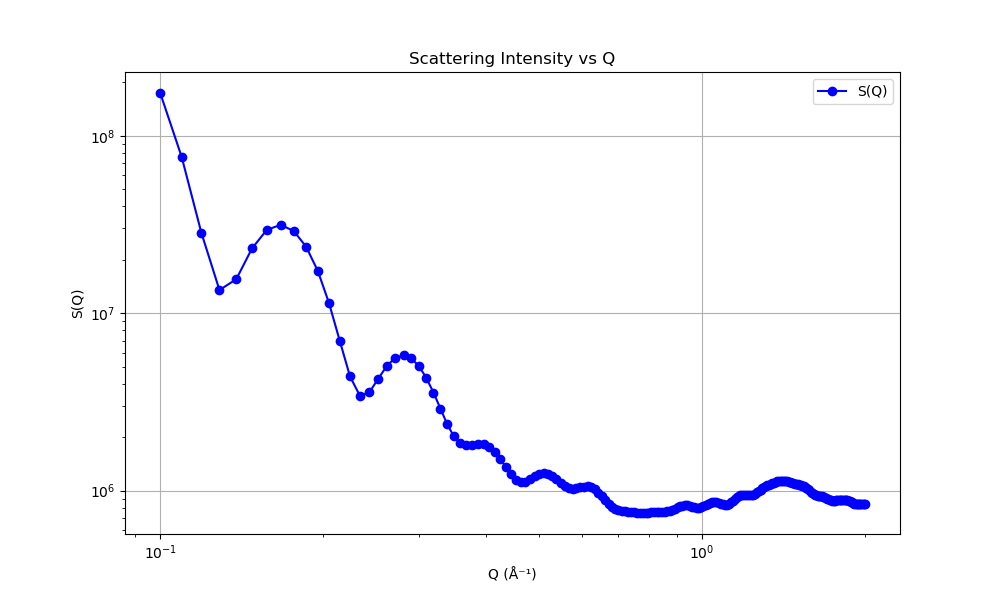

In [6]:
%matplotlib widget

# Path to your XYZ file
# xyzPath = "/Users/keithwhite/repos/debyesim/PbI2_DMSO_0p8M_berendsen_last_frame_update.xyz"
# xyzPath = "/Users/keithwhite/repos/IsoScatter/example/geo-opt_GGA-pbe_COSMO-DMSO_mono_PbX2L4_LDMSO_isoTRANS_final-config_100x100x100.xyz"
xyzPath = "/Users/keithwhite/repos/IsoScatter/example/PbI2_DMSO_0p8M_berendsen_last_frame_update.xyz"

# Define the range of Q values (in inverse angstroms)
qs = np.linspace(0.1, 2, 200)

# Run the simulation to calculate the scattering profile S(Q)
sq_vals = xyz_simulation(xyzPath, qs)

# Plot the scattering intensity S(Q) versus Q
plot_scattering_profile(qs, sq_vals)

In [7]:
output_file = "/Users/keithwhite/repos/IsoScatter/example/tomcalc.txt"
np.savetxt(output_file, np.column_stack((qs, sq_vals)), header='Q (Å⁻¹)  S(Q)', comments='')

#### Pre-Process XYZ Files for Formatting

In [6]:
import os

def preprocess_xyz(input_file, output_file):
    """
    Preprocesses an XYZ file to remove numeric suffixes from atom labels
    and correct the case structure (e.g., 'PB1' to 'Pb').
    
    Parameters:
    - input_file (str): Path to the input XYZ file.
    - output_file (str): Path to save the preprocessed XYZ file.
    """
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        lines = infile.readlines()
        # Write the first two lines as they are (atom count and comment)
        outfile.write(lines[0])
        outfile.write(lines[1])
        
        # Process the atom lines
        for line in lines[2:]:
            parts = line.split()
            if len(parts) != 4:
                # Skip lines that do not have exactly 4 elements
                continue
            
            atom_label = parts[0]
            
            # Remove numeric suffix and correct case
            atom_label = ''.join([i for i in atom_label if not i.isdigit()])
            atom_label = atom_label.capitalize()
            
            # Write the corrected line to the output file
            outfile.write(f"{atom_label:>4} {parts[1]:>10} {parts[2]:>10} {parts[3]:>10}\n")

def preprocess_xyz_folder(input_folder, output_folder):
    """
    Preprocesses all XYZ files in the input folder and saves them to the output folder.
    
    Parameters:
    - input_folder (str): Path to the folder containing the original .xyz files.
    - output_folder (str): Path to the folder where the preprocessed .xyz files will be saved.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Iterate through each .xyz file in the input folder
    for filename in sorted(os.listdir(input_folder)):
        if filename.endswith('.xyz'):
            input_file = os.path.join(input_folder, filename)
            output_file = os.path.join(output_folder, filename)
            
            # Preprocess and save the file
            preprocess_xyz(input_file, output_file)
            print(f"Processed {filename} and saved to {output_file}")

# Example usage:
input_folder = "/Users/keithwhite/repos/debyesim/splitxyz"
output_folder = "/Users/keithwhite/repos/debyesim/splitxyz_processed"
preprocess_xyz_folder(input_folder, output_folder)

print(f"All files in {input_folder} have been processed and saved to {output_folder}.")


Processed frame_0000.xyz and saved to /Users/keithwhite/repos/debyesim/splitxyz_processed/frame_0000.xyz
Processed frame_0001.xyz and saved to /Users/keithwhite/repos/debyesim/splitxyz_processed/frame_0001.xyz
Processed frame_0002.xyz and saved to /Users/keithwhite/repos/debyesim/splitxyz_processed/frame_0002.xyz
Processed frame_0003.xyz and saved to /Users/keithwhite/repos/debyesim/splitxyz_processed/frame_0003.xyz
Processed frame_0004.xyz and saved to /Users/keithwhite/repos/debyesim/splitxyz_processed/frame_0004.xyz
Processed frame_0005.xyz and saved to /Users/keithwhite/repos/debyesim/splitxyz_processed/frame_0005.xyz
Processed frame_0006.xyz and saved to /Users/keithwhite/repos/debyesim/splitxyz_processed/frame_0006.xyz
Processed frame_0007.xyz and saved to /Users/keithwhite/repos/debyesim/splitxyz_processed/frame_0007.xyz
Processed frame_0008.xyz and saved to /Users/keithwhite/repos/debyesim/splitxyz_processed/frame_0008.xyz
Processed frame_0009.xyz and saved to /Users/keithwhite

#### Run a Debye Scattering Calculation (Multiple Frames)

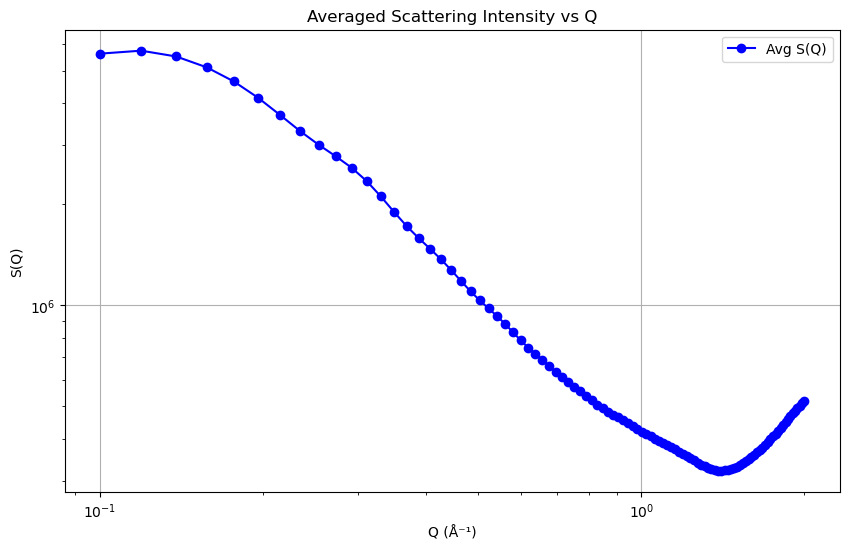

Number of Max Workers:  9


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [7]:
# Define the path to the folder containing .xyz files
folder_path = "/Users/keithwhite/repos/debyesim/splitxyz_processed"

# Define the output folder to save .txt files
output_folder = "/Users/keithwhite/repos/debyesim/saxs_output"

# Define the range of Q values (in inverse angstroms)
qs = np.linspace(0.1, 2, 100)

# Calculate, save, and interactively plot scattering patterns for each .xyz file
calculate_and_save_scattering_interactive(folder_path, output_folder, qs)

## Tom's Cells

In [ ]:

def write_xyz(output_path, coords, elements):
    """
    Writes the molecular structure to an xyz file at the specified path.
    
    Parameters:
    - output_path: string, path where the xyz file will be saved
    - coords: 2D numpy array of x, y, z coordinates
    - elements: 1D numpy array of element symbols corresponding to each row in coords
    """
    if len(coords) != len(elements):
        raise ValueError("Length of coordinates and elements must be the same.")

    # Start writing to the file
    with open(output_path, 'w') as file:
        # Write the number of atoms on the first line
        file.write(f"{len(elements)}\n")
        # Write a comment or blank line on the second line
        file.write("XYZ file generated by write_xyz function\n")

        # Write elements and coordinates to the file
        for element, (x, y, z) in zip(elements, coords):
            file.write(f"{element} {x:.8f} {y:.8f} {z:.8f}\n")

dirr = '/Users/keithwhite/repos/debyesim/debye_alpine/inputs/'
xyz_file = f'{dirr}geo-opt_GGA-PBE_explicit-solvent_implicit-solvent-COSMO-DMF_mono_PbX4L2_LDMF_XI_isoCIS.xyz'
coords, elements = loadXYZ(xyz_file)

x_max = 42.0
y_max = 21.6
z_max = 39.0

# number of adds in each direction
num_x = 3
num_y = 3
num_z = 5

coords_original = coords
elements_original = elements
for i in range(num_x):
    coords_new = coords_original+[x_max*(i+1), 0, 0]
    if i == 0:
        coords_append = coords_new
        elements_append = elements_original
    else:
        coords_append = np.concatenate((coords_append, coords_new), axis=0)
        elements_append = np.concatenate((elements_append, elements), axis=0)  
    if i==num_x-1:
        coords = np.concatenate((coords_original, coords_append), axis=0)
        elements = np.concatenate((elements_original, elements_append), axis=0)

coords_original = coords
elements_original = elements
for i in range(num_y):
    coords_new = coords_original+[0, y_max*(i+1), 0]
    if i ==0:
        coords_append = coords_new
        elements_append = elements_original
    else:
        coords_append = np.concatenate((coords_append, coords_new), axis=0)
        elements_append = np.concatenate((elements_append, elements), axis=0)
    if i==num_y-1:
        coords = np.concatenate((coords_original, coords_append), axis=0)
        elements = np.concatenate((elements_original, elements_append), axis=0)

coords_original = coords
elements_original = elements
for i in range(num_z):
    coords_new = coords_original+[0, 0, z_max*(i+1)]
    if i ==0:
        coords_append = coords_new
        elements_append = elements_original
    else:
        coords_append = np.concatenate((coords_append, coords_new), axis=0)
        elements_append = np.concatenate((elements_append, elements), axis=0)
    if i==num_z-1:
        coords = np.concatenate((coords_original, coords_append), axis=0)
        elements = np.concatenate((elements_original, elements_append), axis=0)

save_path = f'{dirr}JtypeEQ_{num_x+1}x{num_y+1}x{num_z+1}.xyz'
write_xyz(save_path, coords, elements)

In [ ]:
%matplotlib inline
dirr = '/Users/keithwhite/repos/debyesim/debye_alpine/md_sim/'
files = sorted(glob.glob(f'{dirr}pbi2dmso_0p8m/PbI2_DMSO_0p8M_berendsen_resave.xyz'))
qs = np.linspace(0.1, 2, 300)
for i, xyz_file in enumerate(files):
    name = os.path.basename(xyz_file)
    name_short = name[:-4]
    Jeq_sq_vals = xyz_simulation(xyz_file, qs, 1, 0, plot_hull=False)
    Jeq_total = np.vstack((qs, Jeq_sq_vals))
    Jeq_total = np.transpose(Jeq_total)
    np.savetxt(f'{dirr}{name_short}_simdata.txt', Jeq_total)

In [ ]:
%matplotlib inline
dirr = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/OPV_SAXS/debye_waxs_sim/Christine_MD/y_test/'
files = sorted(glob.glob(f'{dirr}JtypeEQ*.xyz'))
qs = np.linspace(0.1, 2, 300)
for i, xyz_file in enumerate(files):
    name = os.path.basename(xyz_file)
    name_short = name[:-4]
    Jeq_sq_vals = xyz_simulation(xyz_file, qs, 1, 0, plot_hull=False)
    Jeq_total = np.vstack((qs, Jeq_sq_vals))
    Jeq_total = np.transpose(Jeq_total)
    np.savetxt(f'{dirr}{name_short}_simdata.txt', Jeq_total)

In [ ]:
%matplotlib inline
dirr = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/OPV_SAXS/debye_waxs_sim/Christine_MD/z_test/'
files = sorted(glob.glob(f'{dirr}JtypeEQ*.xyz'))
qs = np.linspace(0.1, 2, 300)
for i, xyz_file in enumerate(files):
    name = os.path.basename(xyz_file)
    name_short = name[:-4]
    Jeq_sq_vals = xyz_simulation(xyz_file, qs, 1, 0, plot_hull=False)
    Jeq_total = np.vstack((qs, Jeq_sq_vals))
    Jeq_total = np.transpose(Jeq_total)
    np.savetxt(f'{dirr}{name_short}_simdata.txt', Jeq_total)

In [ ]:
%matplotlib widget
fig, ax1 = subplots(1)
dirr = '/Users/keithwhite/repos/debyesim/debye_alpine/inputs/'
files = sorted(glob.glob(f'{dirr}JtypeEQ*_4x4x6_simdata.txt'))
colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(files)))

a = 0.007
power = -4

for i, data_file in enumerate(files):
    name = os.path.basename(data_file)
    name_short = name[:-4]
    sim_data = np.loadtxt(data_file)
    sim_data[:,1][sim_data[:,0]<0.21]=np.nan
    powerlaw_vals = a*sim_data[:,0]**power
    ax1.plot(sim_data[:,0], sim_data[:,1]-powerlaw_vals, label=name_short, color=colors[i])


# ax1.plot(sim_data[:,0], powerlaw_vals, label=name_short, color='black')

plt.legend()
ax1.set_yscale('log')
# ax1.set_ylim(1e-3, 1e3)
# ax1.set_xscale('log')
ax1.set_xlabel('q ($\AA^{-1}$)')
ax1.set_ylabel('Intensity ($cm^{-1}$)')

In [ ]:
%matplotlib widget
fig, ax1 = subplots(1)
dirr = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/OPV_SAXS/debye_waxs_sim/Christine_MD/y_test/'
files = sorted(glob.glob(f'{dirr}JtypeEQ*_simdata.txt'))
colors = plt.cm.Greens(np.linspace(0.4, 0.9, len(files)))

a = 0.007
power = -4

for i, data_file in enumerate(files):
    name = os.path.basename(data_file)
    name_short = name[:-4]
    sim_data = np.loadtxt(data_file)
    sim_data[:,1][sim_data[:,0]<0.21]=np.nan
    powerlaw_vals = a*sim_data[:,0]**power
    ax1.plot(sim_data[:,0], sim_data[:,1]-powerlaw_vals, label=name_short, color=colors[i])


# ax1.plot(sim_data[:,0], powerlaw_vals, label=name_short, color='black')

plt.legend()
ax1.set_yscale('log')
# ax1.set_ylim(1e-3, 1e3)
# ax1.set_xscale('log')
ax1.set_xlabel('q ($\AA^{-1}$)')
ax1.set_ylabel('Intensity ($cm^{-1}$)')

In [ ]:
%%time
dirr = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/OPV_SAXS/debye_waxs_sim/Christine_MD/'
qs = np.linspace(0.1, 2, 300)
xyz_file = f'{dirr}JtypeEQ_4x1x2.xyz'
name = os.path.basename(xyz_file)
name_short = name[:-4]
Jeq_sq_vals = xyz_simulation(xyz_file, qs, 1, 0, plot_hull=False)
Jeq_total = np.vstack((qs, Jeq_sq_vals))
Jeq_total = np.transpose(Jeq_total)
np.savetxt(f'{dirr}{name_short}_simdata.txt', Jeq_total)

In [ ]:
%%time
dirr = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/OPV_SAXS/debye_waxs_sim/Christine_MD/'
qs = np.linspace(0.1, 2, 300)
xyz_file = f'{dirr}HtypeEQ.xyz'
Heq_sq_vals = xyz_simulation(xyz_file, qs, 1, 0, plot_hull=False)
Heq_total = np.vstack((qs, Heq_sq_vals))
Heq_total = np.transpose(Heq_total)

In [ ]:
dirr = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/OPV_SAXS/debye_waxs_sim/Christine_MD/'
xyzPath = f'{dirr}JtypeEQ.xyz'
# Extracting the atomic symbols and positions from the xyz file
with open(xyzPath, 'r') as file:
    lines = file.readlines()
# Extracting atom data
atom_data = [line.split() for line in lines[2:] if len(line.split()) == 4]
symbols, coords = zip(*[(parts[0], np.array(list(map(float, parts[1:])))) for parts in atom_data])
coords = np.array(coords)
x_max = np.max(coords[:,0])
y_max = np.max(coords[:,1])
z_max = np.max(coords[:,2])
x_min = np.min(coords[:,0])
y_min = np.min(coords[:,1])
z_min = np.min(coords[:,2])

In [ ]:
import glob
import os

In [ ]:
%matplotlib widget
fig, ax1 = subplots(1)
exp_dirr = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/OPV_SAXS/debye_waxs_sim/'
exp_data = np.loadtxt(f'{exp_dirr}TC11_th0.15_05to85poscut.txt')
max_exp = np.nanmax(exp_data[:,1])


a = 0.002
power = -4
scale=1

sim_dirr = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/OPV_SAXS/debye_waxs_sim/sim_data/'
for file in glob.glob(f'{sim_dirr}JtypeEQ_2x4x2*.txt'):
    name = os.path.basename(file)
    name_short = name.split('.')[0]
    sim_data = np.loadtxt(file)
    sim_data[:,1][sim_data[:,0]<0.24]=np.nan
    powerlaw_vals = a*sim_data[:,0]**power
    # max_sim = np.nanmax(sim_data[:,1])
    ax1.plot(sim_data[:,0], (sim_data[:,1]-powerlaw_vals)*scale, label=name_short, color='red', linestyle='--')

sim_dirr = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/OPV_SAXS/debye_waxs_sim/sim_data/'
for file in glob.glob(f'{sim_dirr}HtypeEQ_2x4x2*.txt'):
    name = os.path.basename(file)
    name_short = name.split('.')[0]
    sim_data = np.loadtxt(file)
    sim_data[:,1][sim_data[:,0]<0.24]=np.nan
    powerlaw_vals = a*sim_data[:,0]**power
    # max_sim = np.nanmax(sim_data[:,1])
    ax1.plot(sim_data[:,0], (sim_data[:,1]-powerlaw_vals)*scale, label=name_short, color='blue', linestyle='--')



# ax1.plot(Jeq_total[:,0], (Jeq_total[:,1]-powerlaw_vals)*scale, label='Jeq_small', color='blue', linestyle='--')
ax1.plot(exp_data[:,0], exp_data[:,1], label='Experimental Data', color='gray')


# ax1.plot(Jeq_total[:,0], powerlaw_vals, label='power')
plt.legend()
ax1.set_yscale('log')
# ax1.set_ylim(1e-3, 1e3)
# ax1.set_xscale('log')
ax1.set_xlabel('q ($\AA^{-1}$)')
ax1.set_ylabel('Intensity ($cm^{-1}$)')

In [ ]:
# exp_dirr = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/ZnSO4_SAXS/'
# exp_file = exp_dirr + 'SAXS_absolute_1M.csv'

exp_dirr = pathlib.Path('/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/ZnSO4_SAXS/')
exp_file = exp_dirr.joinpath('ZnSO4_1M_H2O.txt')

exp_data = np.loadtxt(exp_file)



# label_list = ['PbI6 + 0DMF', 'PbI5 + 1DMF', 'PbI4 + 2DMF', 'PbI3 + 3DMF', 'PbI2 + 4DMF']
# sq_list = [PbI6_f0_sq_vals, PbI5_f0_sq_vals, PbI4_f0_sq_vals, PbI3_f0_sq_vals, PbI2_f0_sq_vals]
fig, ax1 = subplots(1)
index = find_nearest_index(exp_data, 0.1)
ax1.plot(exp_data[:,0], exp_data[:,1], label ='ZnSO4 in H2O 1M exp data',
         color='black', linestyle='None', marker = '.', markersize=3)
sq1 = snap1_Zn1S2_sq_vals
norm = exp_data[index,1]/sq1[index]
ax1.plot(exp_data[:,0], (sq1*norm), label='snap1_Zn1S2_sim', linestyle='None', marker = '.', markersize=3)
sq2 = snap1_Zn2S2_sq_vals
norm = exp_data[index,1]/sq2[index]
ax1.plot(exp_data[:,0], (sq2*norm), label='snap1_Zn2S2_sim', linestyle='None', marker = '.', markersize=3)
sq3 = snap1_Zn1S1_sq_vals
norm = exp_data[index,1]/sq3[index]
ax1.plot(exp_data[:,0], (sq3*norm), label='snap1_Zn1S1_sim', linestyle='None', marker = '.', markersize=3)

ax1.set_xlabel('q ($\AA^{-1}$)')
ax1.set_ylabel('Intensity ($cm^{-1}$)')
ax1.set_xscale('log')
ax1.set_yscale('log')
for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(14)
ax1.legend(prop={'size': 12})
ax1.set_title('Forward Sim ZnSO4')
plt.tight_layout()
# save_dir = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/pvsk_speciation/foward_sim_figs/'
# plt.savefig(save_dir + 'Pb_noSolvent_DMFBkg.png', dpi=300)
# plt.close('all')

In [ ]:
#fitting with selected curves
from lmfit import Model, Parameters

#experimental data
exp_dirr = pathlib.Path('/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/ZnSO4_SAXS/')
exp_file = exp_dirr.joinpath('ZnSO4_1M_H2O.txt')

exp_data = np.loadtxt(exp_file)

mask = (exp_data[:, 0] >= 0.07) & (exp_data[:, 0] <= 1.00)
# mask = (exp_data[:, 0] >= 0.01) & (exp_data[:, 0] <= 3.7)
filtered_data = exp_data[mask]
q_vals_exp = filtered_data[:,0]
int_vals_exp = filtered_data[:,1]
q_vals_exp_full = exp_data[:, 0]  # The full range of q values
int_vals_exp_full = exp_data[:, 1]  # The full range of q values
# q_vals_exp = exp_data[:,0]
# intensity_vals_exp = exp_data[:,1]

#modeled data (q_values must match experimental)
label_list = ['Zn2S2']
sq_list = [snap1_Zn2S2_sq_vals]
# label_list = ['Zn2S2', 'Zn1S2', 'Zn1S1']
# sq_list = [snap1_Zn2S2_sq_vals, snap1_Zn1S2_sq_vals, snap1_Zn1S1_sq_vals]

def fitting_model_nopeak(w1,bkg,sq1,q_vals,exp_data):
    sq_total = w1*sq1 + bkg
    index_min = find_nearest_index(exp_data, np.min(q_vals))
    index_max = find_nearest_index(exp_data, np.max(q_vals))
    return sq_total[index_min:index_max+1]
# def fitting_model_nopeak(w1,w2,w3,bkg,sq1,sq2,sq3,q_vals,exp_data):
#     sq_total = w1*sq1 + w2*sq2 + w3*sq3 + bkg
#     index_min = find_nearest_index(exp_data, np.min(q_vals))
#     index_max = find_nearest_index(exp_data, np.max(q_vals))
#     return sq_total[index_min:index_max+1]
    
# Create a model object
model = Model(fitting_model_nopeak, independent_vars=['q_vals', 'exp_data', 'sq1'])
# model = Model(fitting_model_nopeak, independent_vars=['q_vals', 'exp_data', 'sq1', 'sq2', 'sq3'])

# Set initial parameter values
params = Parameters()
params.add('w1', value=1, min=0)
# params.add('w2', value=1, min=0)
# params.add('w3', value=1, min=0)
params.add('bkg', value=5e-2, min=0)

# Perform the fit
result = model.fit(int_vals_exp, params, q_vals=q_vals_exp, exp_data=exp_data, sq1=sq_list[0])

#plot results
best_fit_full = fitting_model_nopeak(**result.params, sq1=sq_list[0], q_vals=q_vals_exp_full, exp_data=exp_data)

# # Perform the fit
# result = model.fit(int_vals_exp, params, q_vals=q_vals_exp, exp_data=exp_data, sq1=sq_list[0], sq2=sq_list[1], sq3=sq_list[2])

# #plot results
# best_fit_full = fitting_model_nopeak(**result.params, sq1=sq_list[0], sq2=sq_list[1], sq3=sq_list[2], q_vals=q_vals_exp_full, exp_data=exp_data)


fig, ax1 = subplots(1)
ax1.plot(q_vals_exp_full, int_vals_exp_full, linestyle='None', marker='.',markersize=3, color='black', label='Experimental Data')
ax1.plot(q_vals_exp_full, best_fit_full, linestyle='--', label='Best Fit_full')
for i, sq in enumerate(sq_list):
    weight = result.params[f'w{i+1}'].value
    ax1.plot(exp_data[:,0], sq*weight, label=label_list[i])
ax1.plot(exp_data[:,0], np.full_like(exp_data[:,0],result.params['bkg'].value), label='background', color='grey', linestyle='--')

ax1.set_xlabel('q ($\AA^{-1}$)')
ax1.set_ylabel('Intensity ($cm^{-1}$)')
ax1.set_xscale('log')
ax1.set_yscale('log')
# ax1.set_ylim(5e-3,0.2)
for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(14)
ax1.legend(prop={'size': 12})
ax1.set_title('Fit ZnSO4 in H2O 1M')
plt.tight_layout()


# Print the fit results
print(result.fit_report())

In [ ]:
result.params['bkg'].value

In [ ]:
#effect of solvent density
exp_file = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/pvsk_speciation/Perovskite_SAXS/subtracted_new/PbI2_DMF_MolaritySeries2/PbI2_DMF_0p5M_sol398_buf389_emp337.txt'
xyz_file = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/pvsk_speciation/Pb_solvate_structure_generator/corner_solvbl3/corner_2Pb_3SolvperPb_45dihedral.xyz'
exp_data = np.loadtxt(exp_file)

edensities = np.linspace(0,1,num=5)

fig, ax1 = subplots(1)
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.cool(np.linspace(0, 1, len(edensities)))))
for edens in edensities:
    PbI3_sq_vals = xyz_simulation(xyz_file, exp_file,  edens, plot_hull=False)
    ax1.plot(exp_data[:,0], PbI3_sq_vals, label =f'solvent= {edens:.2f} e/Å^3', linestyle='None', marker = '.', markersize=3)
    
    
    
ax1.set_xlabel('q ($\AA^{-1}$)')
ax1.set_ylabel('Intensity ($cm^{-1}$)')
ax1.set_xscale('log')
ax1.set_yscale('log')
for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(14)
ax1.legend(prop={'size': 12})
ax1.set_title('Varying Solvent Density for Pb2I5 + 3DMF Simulation')
plt.tight_layout()
plt.savefig(save_dir + 'solvent_dens_Pb2I5.png', dpi=300)